In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import xml.etree.ElementTree as ET
import os
import glob

%matplotlib widget
pd.options.mode.chained_assignment = None  # default='warn'


def butterworth_filter(data, cutoff, fs, order=3):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

def extract_from_txt(file_path, labels, delimiter='\n'):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    data_dict = {label: [] for label in labels}
    last_delimiter_index = 0
    messages = []
    for i in range(len(lines)):
        if(lines[i].startswith(delimiter)):
            messages.append(lines[last_delimiter_index:i])
            last_delimiter_index = i
    for message in messages:
        message_dict = {label: [] for label in labels}
        for label in labels:
            for line in message:
                    if(line.startswith(label)):
                        message_dict[label].append(float(line.split(':')[1]))
        full = True
        for key in message_dict:
            if(len(message_dict[key]) == 0):
                full=False
                break
        if(full):
            for label in labels:
                data_dict[label].append(message_dict[label][0])

    # for series in data_dict:
    #     print(series, len(data_dict[series]))

    df_raw = pd.DataFrame(data_dict)
    return df_raw

def remove_even_lines(input_file_path, output_file_path):
    with open(input_file_path, 'r') as file:
        lines = file.readlines()
    
    with open(output_file_path, 'w') as file:
        for i, line in enumerate(lines):
            if i % 2 == 0:
                file.write(line)

def extract_fps(xml_string):
    root = ET.fromstring(xml_string)
    video_frame = root.find('.//*[@captureFps][@formatFps]')
    if video_frame is not None:
        capture_fps = str(video_frame.get('captureFps'))
        format_fps = str(video_frame.get('formatFps'))
        return float(capture_fps[:-1]), float(format_fps[:-1])
    else:
        return np.nan, np.nan
    
'''
(0,0) for alignment is min motor position, min encoder angle.
The motor goes negative to make the encoder increase (string contracts).
See stringA.pdf and stringB.pdf
'''
stringA_coeffs = [26148, -0.085962, 9.3003e-08, -3.168e-14, -1.4821e-21]
stringB_coeffs = [9885.9, -0.092574, 4.1792e-07, -1.197e-12, 1.5461e-18]

In [2]:
encoder_file = max(glob.glob('./data/*encoder.txt'), key=os.path.getctime)
force_file = max(glob.glob('./data/*force.txt'), key=os.path.getctime)
track_file = max(glob.glob('./data/*track.csv'), key=os.path.getctime)
xml_file = max(glob.glob('./data/*.XML'), key=os.path.getctime)

df_log = extract_from_txt(
    encoder_file, 
    [
        't',
        'pA',
        'pB',
        'mA',
        'mB',
        'eA', 
        'eB', 
        'I',
        'd0',
        'd1',
        'd2',
        'd3',
        'd4',
    ],
    '#'
)

force_data_path = force_file[:-4] + '_filt.txt'
remove_even_lines(force_file, force_data_path)
df_force = extract_from_txt(
    force_data_path, 
    [
        'elapsed',
        'looptime',
        'N23', 
        'N67'
    ],
    '\n'
)

xml_content = open(xml_file, 'r').read()
capture_fps, format_fps = extract_fps(xml_content)
playback_speed = format_fps / capture_fps

print(f"XML: {xml_file}")
print(f"track.csv: {track_file}")
print(f"Capture FPS: {capture_fps}")
print(f"Format FPS: {format_fps}")
print(f"playback_speed: {playback_speed}")

df_vid = pd.read_csv(track_file)
print(f"frames: {len(df_vid)}")


df_log.loc[:,'time'] = df_log.loc[:,'t'] / 1e3
df_log['side_enc_pos'] = df_log['eA'] - df_log['eA'][0]
df_log['center_enc_pos'] = df_log['eB'] - df_log['eB'][0]
df_log['side_mot_pos'] = -(df_log['mA']-df_log['mA'][0])
df_log['center_mot_pos'] = -(df_log['mB']-df_log['mB'][0])
df_log['side_mot_pow'] = -df_log['pA']
df_log['center_mot_pow'] = -df_log['pB']

df_force.loc[:,'time'] = np.cumsum(df_force['looptime']) / 1e6
df_force['Fx'] = -df_force['N23']
df_force['Fy'] = df_force['N67']

df_vid['time'] = df_vid['t'] * playback_speed
df_vid['Bx_vel'] = df_vid['Bx'].diff() / df_vid['time'].diff()
df_vid['By_vel'] = df_vid['By'].diff() / df_vid['time'].diff()
df_vid['Bx_vel'][0] = df_vid['Bx_vel'][1]
df_vid['By_vel'][0] = df_vid['By_vel'][1]
df_vid['v_com'] = np.linalg.norm([df_vid['Bx_vel'], df_vid['By_vel']], axis=0)

df_log['dv0'] = df_log['d0'].diff()/df_log['time'].diff()
# i_log_dxl_start = df_log[df_log['dv0'] > 1200].index[0] - 1
i_log_dxl_start = df_log[df_log['d0'] > 1060].index[0] - 1
t_dxl_start = df_log['time'][i_log_dxl_start] - 0.02

df_vid['By_vel_filt'] = butterworth_filter(df_vid['v_com'], 20, capture_fps)
i_vid_liftoff = df_vid['By_vel_filt'].idxmax()
t_vid_liftoff = df_vid['time'][i_vid_liftoff]

df_force['net_force'] = np.sqrt(df_force['Fx']**2 + df_force['Fy']**2)
i_force_liftoff = df_force[df_force['net_force'] > 0.5].index[-1]
t_force_liftoff = df_force['time'][i_force_liftoff]

i_motorstart = df_log[df_log['side_mot_pow'] > 100].index[0]
t_motor_start = df_log['time'][i_motorstart]

side_enc_thres = max(df_log['side_enc_pos']) - 1000
i_motor_end = df_log[df_log['side_enc_pos'] > side_enc_thres].index[0]
t_motor_end = df_log['time'][i_motor_end]


# synchronize df_log, df_force, and df_vid on the liftoff/motor_end time, but set the zero to t_dxl_start
df_log.loc[:,'time'] = df_log.loc[:,'time'] - t_dxl_start

offset_force_log = t_force_liftoff - t_motor_end
df_force.loc[:,'time'] = df_force.loc[:,'time'] - t_dxl_start - offset_force_log
t_force_liftoff = t_motor_end - t_dxl_start

offset_vid_log = t_vid_liftoff - t_motor_end
df_vid.loc[:,'time'] = df_vid.loc[:,'time'] - t_dxl_start - offset_vid_log
t_vid_liftoff = t_motor_end - t_dxl_start

t_motor_start = t_motor_start - t_dxl_start
t_motor_end = t_motor_end - t_dxl_start

t_dxl_start = 0

time_before = 0.2
time_after = 0.5
df_log = df_log[df_log['time'] >  - time_before]
df_log = df_log[df_log['time'] <  + time_after]
df_log = df_log.reset_index()
df_force = df_force[df_force['time'] >  - time_before]
df_force = df_force[df_force['time'] <  + time_after]
df_force = df_force.reset_index()
df_vid = df_vid[df_vid['time'] >  - time_before]
df_vid = df_vid[df_vid['time'] <  + time_after]
df_vid = df_vid.reset_index()



#rezero after the time range
df_log['side_enc_pos'] = df_log['eA'] - df_log['eA'][0]
df_log['center_enc_pos'] = df_log['eB'] - df_log['eB'][0]
df_log['side_mot_pos'] = -(df_log['mA']-df_log['mA'][0])
df_log['center_mot_pos'] = -(df_log['mB']-df_log['mB'][0])

# display(df_log, df_force)

XML: ./data/C0045M01.XML
track.csv: ./data/c0045_track.csv
Capture FPS: 479.52
Format FPS: 29.97
playback_speed: 0.0625
frames: 275


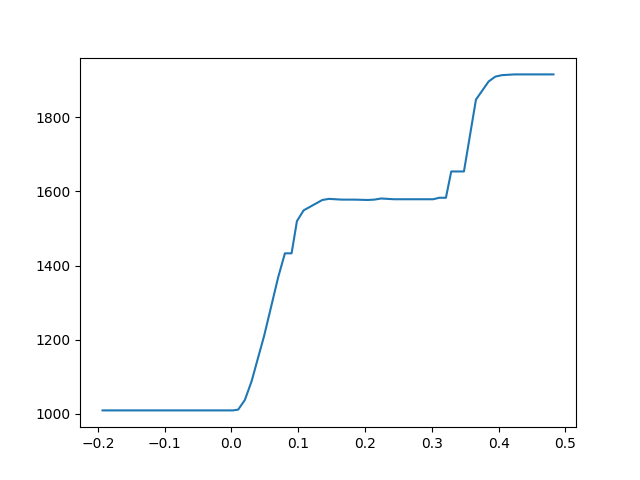

In [3]:
plt.figure()
plt.plot(df_log['time'], df_log['d0'])

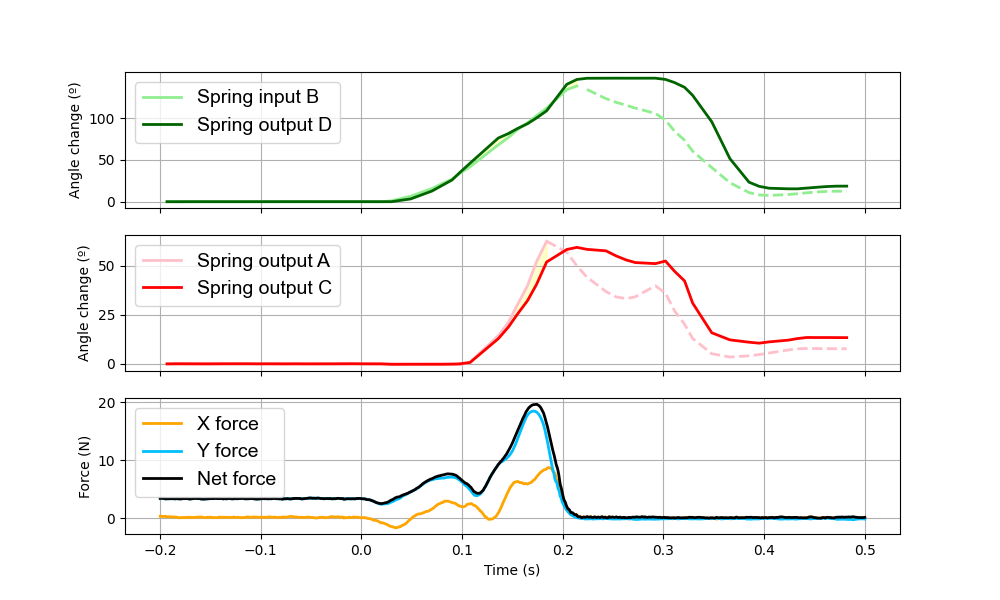

In [4]:
def remove_offset(data):
    return data - data[0]

def enc_to_deg(enc):
    return enc / (2**16) * 360
    

fig, axs = plt.subplots(3, 1, figsize=(10,6), sharex=True)
# fig.tight_layout()


plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14  # Increase font size

from numpy.polynomial import Polynomial
def polyA(motor_pos):
    if motor_pos < 1e6:
        return Polynomial(stringA_coeffs)(motor_pos)
    else:
        return 0
polyA = np.vectorize(polyA)
def polyB(motor_pos):
    if motor_pos < 300000:
        return Polynomial(stringB_coeffs)(motor_pos)
    else:
        return 0
polyB = np.vectorize(polyB)
# polyB = Polynomial(stringB_coeffs)

motorA_zeroed = df_log['mA'] - min(df_log['mA'])
springA_uncomp = remove_offset(polyA(motorA_zeroed))

# axs[0].plot(df_log['time'], enc_to_deg(springA_uncomp), '-', color='lightgreen', label='linkB')
slackA = (df_log['time'] < 0.22)

axs[0].set_ylabel('Angle change (º)')
axs[0].yaxis.set_ticks(np.arange(0, 101, 50))
axs[0].plot(df_log['time'][slackA], enc_to_deg(springA_uncomp)[slackA], '-', color='lightgreen', label='Spring input B', linewidth=2)
axs[0].plot(df_log['time'][~slackA], enc_to_deg(springA_uncomp)[~slackA], '--', color='lightgreen', linewidth=2)
# axs[0].plot(df_log['time'], remove_offset(df_log['side_mot_pos']) / 3500, '-', color='lightgreen', label='motorB (scaled)')
axs[0].plot(df_log['time'], enc_to_deg(remove_offset(df_log['eA'])), '-', color='darkgreen', label='Spring output D', linewidth=2)

top = enc_to_deg(remove_offset(df_log['eA']))[slackA]
bottom = enc_to_deg(springA_uncomp)[slackA]
axs[0].fill_between(df_log['time'][slackA], top, bottom, color='yellow', alpha=0.2)


motorB_zeroed = df_log['mB'] - min(df_log['mB'])
springB_uncomp = (polyB(motorB_zeroed))

slackB = (df_log['time'] < 0.195)
slackB_next = (df_log['time'] < 0.18)

fudge_factor = 1.15 #because of string stretch at load

axs[1].set_ylabel('Angle change (º)')
axs[1].plot(df_log['time'][slackB], enc_to_deg(springB_uncomp)[slackB]*fudge_factor, '-', color='pink', label='Spring output A', linewidth=2)
axs[1].plot(df_log['time'][~slackB_next], enc_to_deg(springB_uncomp)[~slackB_next]*1.15, '--', color='pink', linewidth=2)
# axs[1].plot(df_log['time'], remove_offset(df_log['center_mot_pos']) / 7000, '-', color='pink', label='motorA (scaled)')
axs[1].plot(df_log['time'], enc_to_deg(remove_offset(df_log['eB'])), '-', color='red', label='Spring output C', linewidth=2)

top = enc_to_deg(remove_offset(df_log['eB']))[slackB]
bottom = enc_to_deg(springB_uncomp)[slackB]*fudge_factor
axs[1].fill_between(df_log['time'][slackB], top, bottom, color='yellow', alpha=0.2)


axs[2].set_ylabel('Force (N)')
axs[2].plot(df_force['time'], df_force['Fx'], 'orange', label='X force', linewidth=2)
axs[2].plot(df_force['time'], df_force['Fy'], 'deepskyblue', label='Y force', linewidth=2)
axs[2].plot(df_force['time'], np.sqrt(df_force['Fx']**2 + df_force['Fy']**2), 'black', label='Net force', linewidth=2)
# axs[2].set_ylabel('Force (N)')
# axs[2].set_xlabel("Time (s)")
# for vline in vlines:
#     axs[2].axvline(x=vline, color='k', linestyle='--')

axs[2].set_xlabel('Time (s)')
for ax in axs:
    ax.legend(loc='upper left')
    ax.grid()

import os
current_directory = os.getcwd()
dirname = current_directory.split(os.sep)[-1]
plt.savefig(f"{dirname}.pdf")
